In [1]:
import pandas as pd
import pickle
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gc
%matplotlib inline

## load in data
Player_stats and Opp_stats files have been pulled in from the [nflgame API](http://pdoc.burntsushi.net/nflgame) via the nflgame_acquire.ipynb scripts

In [2]:
path = './data/'
files = os.listdir(path)
player_stats_files = sorted([(int(re.sub('[^0-9]', '', f)), path + f)
                             for f in files if "player" in f], key=lambda x: x[0])
opp_stats_files = sorted([(int(re.sub('[^0-9]', '', f)), path + f)
                          for f in files if "opp" in f], key=lambda x: x[0])

player_dfs = {}
for year, fn in player_stats_files:
    df = pd.read_csv(fn, index_col=0)
    df['team'] = df['team'].str.replace('JAX','JAC')
    df['team'] = df['team'].str.replace('LAC','SD')
    df['team'] = df['team'].str.replace('STL','LA')
    del df['position_fill']
    df['year'] = year
    player_dfs[year] = df

opp_dfs = {}
for year, fn in opp_stats_files:
    df = pd.read_csv(fn, index_col=0)
    df['year'] = year
    df['opp_TEAM'] = df['opp_TEAM'].str.replace('JAX','JAC')
    df['opp_OPP'] = df['opp_OPP'].str.replace('JAX','JAC')
    df['opp_TEAM'] = df['opp_TEAM'].str.replace('LAC','SD')
    df['opp_OPP'] = df['opp_OPP'].str.replace('LAC','SD')
    df['opp_TEAM'] = df['opp_TEAM'].str.replace('STL','LA')
    df['opp_OPP'] = df['opp_OPP'].str.replace('STL','LA')
    opp_dfs[year] = df

new_opp_cols = ['offense', 'defense', 'opp_first_downs', 'opp_points',
       'opp_passing_yds', 'opp_penalty_cnt', 'opp_penalty_yds', 'opp_pos_time',
       'opp_punt_avg', 'opp_punt_cnt', 'opp_punt_yds', 'opp_rushing_yds',
       'opp_total_yds', 'opp_turnovers', 'week', 'year']

for year, df in opp_dfs.items():
    df.columns = new_opp_cols
    opp_dfs[year] = df

In [3]:
for year in range(2013,2018):
    print(player_dfs[year].shape)

(13827, 79)
(14124, 79)
(14151, 79)
(14149, 79)
(10592, 79)


## clean data and create target variable

In [4]:
# missing positions
data = pd.concat(player_dfs.values())
missing_positions = data[data.position.isnull()]
means = missing_positions.groupby(['id','full_name'], as_index=False).mean()
means = means[['id','full_name','passing_att', 'rushing_att', 'receiving_rec']]
means.columns = ['id','full_name','QB','RB','WRTE']
means = means[(means.QB != 0) | (means.RB != 0) | (means.WRTE != 0)]
means['position_fill'] = means[['QB','RB','WRTE']].idxmax(axis=1)
means = means[['id','position_fill']]
means['position_fill'] = means['position_fill'].apply(lambda x: np.nan if x == 'WRTE' else x)
# means[means.position=='WRTE'].full_name.unique()
# missing_positions_urls = means.profile_url.unique().tolist()
# with open('data/missing_positions_fills.pkl', 'wb') as f:
#     pickle.dump(means, f)

In [5]:
from data.missing_plyrs import missing_WRTE

def fill_positions(name):
    """Fill missing positions for players who are retired. The nflgame players.json 
    will not update these positions, nor are the positions available by scraping each
    player's nfl.com profile url."""
    try:
        pos = missing_WRTE[name]
        return pos
    except KeyError:
        return ''

def clean(player_stats, year, imputed):
    """Create fantasy_points (the target variable) according to a standard scoring regime.
       Create pass/rush/reception ratios to be included in feature set for model.
       Trim the dataset to include the four main offensive positions: QB, RB, WR, TE."""
    
    player_stats['fantasy_points'] = (player_stats['passing_tds'] * 4) +\
    (player_stats['passing_yds'] * 0.04) +\
    (player_stats['passing_twoptm'] * 2) +\
    (player_stats['passing_ints'] * -2) +\
    (player_stats['rushing_tds'] * 6) +\
    (player_stats['rushing_yds'] * 0.1) +\
    (player_stats['rushing_twoptm'] * 2) +\
    (player_stats['receiving_tds'] * 6) +\
    (player_stats['receiving_yds'] * 0.1) +\
    (player_stats['receiving_twoptm'] * 2) +\
    (player_stats['kickret_tds'] * 6) +\
    (player_stats['puntret_tds'] * 6) +\
    (player_stats['fumbles_lost'] * -2)
    
    player_stats['passer_ratio'] = player_stats['passing_cmp']/player_stats['passing_att']
    player_stats['PassRushRatio_Att'] = player_stats['rushing_att'] / player_stats['passing_att']
    player_stats['PassRushRatio_Yds'] = player_stats['rushing_yds'] / player_stats['passing_yds']
    player_stats['PassRushRatio_Tds'] = player_stats['rushing_tds'] / player_stats['passing_tds']
    player_stats['RushRecRatio_AttRec'] = player_stats['rushing_att'] / player_stats['receiving_rec']
    player_stats['RushRecRatio_Tds'] = player_stats['rushing_tds'] / player_stats['receiving_tds']
    player_stats['RushRecRatio_Yds'] = player_stats['rushing_yds'] / player_stats['receiving_yds']
    
    player_stats = player_stats.merge(imputed, how='left', on='id')
    player_stats['position'].fillna(player_stats['position_fill'], inplace=True)
    player_stats['position_fill'] = player_stats['full_name'].apply(lambda x: fill_positions(x))
    player_stats['position'].fillna(player_stats['position_fill'], inplace=True)
 
    include_positions = ['QB', 'TE', 'WR', 'RB']
    player_stats['position'] = player_stats['position'].str.replace('FB','RB')
    player_stats = player_stats[player_stats['position'].isin(include_positions)]
    return player_stats

In [6]:
# Create dictionary with keys as year of the NFL season and values 
# as a dataframe containing game summary stats for all players in that season
player_dfs = {year:clean(df, year, means) for year, df in player_dfs.items()}

for year in range(2013,2018):
    print(player_dfs[year].shape)

(4186, 88)
(4499, 88)
(4764, 88)
(4908, 88)
(3740, 88)


## feature engineering

In [7]:
# These are the game summary stats relevant to QB, RB, WR, and TE positions.

stat_cols = ['fumbles_lost', 'fumbles_rcv', 'fumbles_tot','fumbles_trcv', 'fumbles_yds', 
       'passing_att', 'passing_cmp', 'passing_ints', 'passing_tds', 'passer_ratio',
       'passing_twopta', 'passing_twoptm', 'passing_yds',
       'puntret_tds','puntret_avg', 'puntret_lng', 'puntret_lngtd', 'puntret_ret',
       'receiving_lng', 'receiving_lngtd','receiving_rec', 'receiving_tds', 'receiving_twopta',
       'receiving_twoptm', 'receiving_yds', 'rushing_att', 'rushing_lng',
       'rushing_lngtd', 'rushing_tds', 'rushing_twopta', 'rushing_twoptm',
       'rushing_yds','fantasy_points',
        'PassRushRatio_Att','PassRushRatio_Yds','PassRushRatio_Tds','RushRecRatio_AttRec',
        'RushRecRatio_Tds','RushRecRatio_Yds']

In [8]:
def trim_sort(df):
    df = df.sort_values(['id','week'])
    df = df[stat_cols+['id','week','team','position','full_name']]
    return df

def get_trend(df):
    
    """Compute a three-week trend for each game statistic, for each player."""
    
    # compute 3-week and 2-week points deltas
    deltas = df.groupby(['id']).pct_change()
    deltas = deltas.add_prefix('chg_')
    deltas = pd.concat([df, deltas], axis=1)
    deltas2 = deltas.groupby(['id'])[deltas.columns].shift(1).fillna(0)
    deltas3 = deltas.groupby(['id'])[deltas.columns].shift(2).fillna(0)
    deltas2 = deltas2.add_prefix('per2_')
    deltas3 = deltas3.add_prefix('per3_')
    trend_df = pd.concat([deltas, deltas2, deltas3], axis=1)
    # average prior three deltas to get trend
    for col in stat_cols:
        name = 'trend_'+col
        trend_df[name] = trend_df[['chg_'+col,'per2_chg_'+col,'per3_chg_'+col]].mean(axis=1).fillna(0)
    return trend_df

def get_cumul_mean_stats(df, weeks):
    
    """Create a rolling mean for each statistic by player, by week."""
    
    weeks_stats_mean = []
    for week in weeks:
        tmp = df[df.week <= week]
        tmp = tmp.groupby(['id'])[stat_cols].mean().reset_index()
        tmp = tmp.add_suffix('_mean')
        tmp['week'] = week
        weeks_stats_mean.append(tmp)
    cumavg_stats = pd.concat(weeks_stats_mean)
    cumavg_stats = cumavg_stats.rename(columns={'id_mean':'id'})
    return cumavg_stats

def get_cumul_stats_time_weighted(df, weeks):
    
    """Create a rolling time-wegihted mean for each statistic by player, by week."""
    
    weeks_stats_mean_wgt = []
    for week in weeks:
        tmp1 = df[df.week <= week]
        mult = lambda x: np.asarray(x) * np.asarray(tmp1.week)
        tmp = tmp1[['id']+stat_cols].set_index('id').apply(mult).reset_index()
        tmp = tmp.groupby(['id'])[stat_cols].mean().reset_index()
        tmp = tmp.add_suffix('_wgtmean')
        tmp['week'] = week
        weeks_stats_mean_wgt.append(tmp)
    cumavg_stats_wgt = pd.concat(weeks_stats_mean_wgt)
    cumavg_stats_wgt = cumavg_stats_wgt.rename(columns={'id_wgtmean':'id'})
    return cumavg_stats_wgt

def defensive_ptsallow(matchups, weeks, weighted=False):
    
    """ Compute the mean weekly points given up by each defense to each position.
        Parameters:
                    matchups: dataframe of matchups between offensive player, and
                              defensive opponent.
                    weeks:    list of weeks in the season.
                    weighted: boolean. If true, compute weekly points allowed according
                              to player-weighted fantasy points.
    """
    
    agg_col = 'fantasy_points'
    output_name = 'defensive_matchup_allowed'
    if weighted:
        agg_col = 'weighted_fantasy_points'
        output_name = 'defensive_matchup_allowed_wgt'
    # compute weekly cumulative mean points allowed by each defense
    defense_ranks_dfs = []
    for week in weeks:
        matchweek = matchups[matchups.week <= week]
        # weekly sum of pts allowed by a given defense to each position
        weekly_sums = matchweek.groupby(['week','defense','position'])[agg_col].sum().reset_index()
        # season-to-date mean of weekly sums for each position
        defense_pts_allowed = weekly_sums.groupby(['defense','position'])[agg_col].mean().reset_index()
        defense_pts_allowed = defense_pts_allowed.rename(columns={agg_col:output_name})
        defense_pts_allowed['week'] = week
        defense_ranks_dfs.append(defense_pts_allowed)
    defense_ranks = pd.concat(defense_ranks_dfs)
    return defense_ranks

def weekly_player_weights(matchups, weeks):
    
    """Calculate season-to-date (STD) weekly fantasy points rankings by position."""
    
    player_weights = []
    for week in weeks:
        mask = (matchups.week <= week)
        # each player's mean fantasy points STD
        std_mean = matchups[mask][['id','team','position','fantasy_points','defense']]
        std_mean = std_mean.groupby(['position','id'], as_index=False).mean()

        # each player's weight in a given week with respect to their position.
        # This is the STD mean max-normalized for the current week.
        week_max_position = std_mean.groupby('position', as_index=False).max()
        week_max_position = week_max_position[['position','fantasy_points']]
        week_max_position.columns = ['position','fp_max']
        weekly_weights = std_mean.merge(week_max_position,how='left',on='position')
        weekly_weights['player_weight'] = weekly_weights['fantasy_points'] / weekly_weights['fp_max']
        weekly_weights['week'] = week
        player_weights.append(weekly_weights)
    player_weights = pd.concat(player_weights)
    return player_weights[['id','week','position','player_weight']]

def create_nfl_features(player_stats_orig, opp_stats_orig):
    
    """Wrapper function that calls all helpers to create custom player and team
       defense stats. This function will return a new dataframe that has merged
       all of the custom stats described in the helper functions for each player.
       
       Parameters:
                   player_stats_orig: game summary actuals for each player weekly
                   opp_stats_orig:    matchups for each game (can substitute with
                                      a schedule with player_id, offense, defense, week)"""
    
    player_stats_trimmed = trim_sort(player_stats_orig)
    weeks = sorted(player_stats_trimmed.week.unique().tolist())

    # create offensive player stats
    trend_df         = get_trend(player_stats_trimmed)
    cumavg_stats     = get_cumul_mean_stats(player_stats_trimmed, weeks)
    cumavg_stats_wgt = get_cumul_stats_time_weighted(player_stats_trimmed, weeks)

    # create matchups and defensive opponent stats
    matchup_cols = ['id', 'week', 'team','position', 'full_name', 'offense', 'defense','fantasy_points']
    sched             = opp_stats_orig[['offense','defense','week']]
    matchups          = player_stats_trimmed.merge(sched, how='left',
                                                   left_on=['week','team'],
                                                   right_on=['week','offense'])[matchup_cols]
    defense_ranks     = defensive_ptsallow(matchups, weeks)
    player_weights    = weekly_player_weights(matchups, weeks)
    player_weights['inverse'] = 1/player_weights.player_weight
    matchups_wgts     = matchups.merge(player_weights, how='left', on=['id','week','position'])
    matchups_wgts['weighted_fantasy_points'] = matchups_wgts['fantasy_points'] * matchups_wgts['inverse']
    defense_ranks_wgt = defensive_ptsallow(matchups_wgts, weeks, weighted=True)
    
    ## merge features

    # shift target variable, week, and defensive opponent
    matchups['target_defense'] = matchups.sort_values(['id','week']).groupby('id')['defense'].shift(-1)
    matchups['target'] = matchups.sort_values(['id','week']).groupby('id')['fantasy_points'].shift(-1)
    matchups['target_week'] = matchups.sort_values(['id','week']).groupby('id')['week'].shift(-1)

    # drop week 1
    matchups.dropna(inplace=True)

#     # fill in zeros for players with missing historical stats
#     matchups.fillna(0, inplace=True)

    # merge player weights to player performances
    matchups = matchups.merge(player_weights, on=['id','week','position'])

    # merge defense rankings to player performances
    defense_ranks_all = defense_ranks.merge(defense_ranks_wgt, on=['defense', 'position', 'week'])
    defense_ranks_all = defense_ranks_all.rename(columns={'defense':'target_defense'})
    matchups = matchups.merge(defense_ranks_all, how='left', on=['target_defense','position','week']).dropna()

    # merge trend, average, and weighted avg stats to player performances
    avgs = cumavg_stats.merge(cumavg_stats_wgt,how='inner',on=['id','week'])
    matchups = matchups.merge(avgs, how='left', on=['id','week'])
    trend_cols = ['id','week']+[col for col in trend_df if col not in matchups.columns]
    td = trend_df[trend_cols]
    matchups = matchups.merge(td, how='inner', on=['id','week'])
    for col in trend_df.columns:
        matchups[col].fillna(0, inplace=True)

    # create extra player attributes and merge to make model-ready df
    attribs = ['id','birthdate','years_pro','height','weight','position','profile_url','last_name','number']
    player_attributes = player_stats_orig[attribs]
    player_attributes.drop_duplicates(['id'],inplace=True)
    player_attributes['birthdate'] = pd.to_datetime(player_attributes['birthdate'])
    player_attributes['age'] = player_attributes['birthdate'].apply(lambda x: (datetime.today() - x).days/365)
    position_dummies = pd.get_dummies(player_attributes['position'])
    player_attributes = pd.concat([position_dummies, player_attributes], axis=1).drop(['position'],axis=1)

    # final cleaning
    model_df = player_attributes.merge(matchups, how='right',on='id')
    model_df.replace([-np.inf,np.inf], 0, inplace=True)
    return model_df

In [9]:
nfl_dfs = {year:create_nfl_features(df, opp_dfs[year]) 
                         for year, df in player_dfs.items()}

/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

## merge FanDuel salaries
I used FanDuel salaries because it was the only DFS service which has weekly historical salaries that go back to 2013 season. I scraped salaries from the [RotoGuru repo](http://rotoguru1.com/cgi-bin/fyday.pl?game=fd)

In [10]:
path = './data/FanDuel/'
files = os.listdir(path)
fanduel_dfs = {}
for fn in files:
    yr = int(re.sub('[^0-9]', '', fn))
    fanduel_dfs[yr] = pd.read_csv(path+fn)

In [11]:
def clean_salaries(df, year):
    positions = ['QB', 'RB', 'WR', 'TE']
    df['FirstName'] = df['FirstName'].str.strip()
    df['LastName'] = df['LastName'].str.strip()
    df['full_name'] = df['LastName']+' '+df['FirstName']
    df = df[df.Pos.isin(positions)].fillna(0)[['Week','Team','full_name','fd_points','fd_salary']]
    df.columns = ['week','team','full_name','fd_points','fd_salary']
    df['week'] = pd.to_numeric(df['week'])
    df['fd_points'] = pd.to_numeric(df['fd_points'])
    df['fd_salary'] = pd.to_numeric(df['fd_salary'])
    df['team'] = df['team'].str.upper()
    df['team'] = df['team'].str.replace('KAN','KC')
    df['team'] = df['team'].str.replace('GNB','GB')
    df['team'] = df['team'].str.replace('LAR','LA')
    df['team'] = df['team'].str.replace('STL','LA')
    df['team'] = df['team'].str.replace('TAM','TB')
    df['team'] = df['team'].str.replace('SFO','SF')
    df['team'] = df['team'].str.replace('NOR','NO')
    df['team'] = df['team'].str.replace('NWE','NE')
    df['team'] = df['team'].str.replace('SDG','SD')
    df['team'] = df['team'].str.replace('LAC','SD')
    return df

def merge_salaries(players, salaries):
    new_players = {}
    for year in players.keys():
        players_year = players[year]
        salaries_year = clean_salaries(salaries[year], year)
        players_teams = set(players_year.team)
        salaries_teams = set(salaries_year.team)
        # check that there are no team naming conflicts
        print(year, salaries_teams ^ players_teams)
        salary_merge = players_year.merge(salaries_year,how='left',on=['week','full_name','team'])
        new_players[year] = salary_merge.fillna(0)
    return new_players

In [12]:
nfl_fanduel_dfs = merge_salaries(nfl_dfs, fanduel_dfs)

2016 set()
2017 set()
2013 set()
2014 set()
2015 set()


In [13]:
# Year column got lost when I called create_nfl_features() on 
# each dataframe, so I am adding it back

def add_year(df, yr):
    df['year'] = yr
    return df

for year in nfl_fanduel_dfs.keys():
    df_year = nfl_fanduel_dfs[year]
    nfl_fanduel_dfs[year] = add_year(df_year, year)

## merge snap counts
Snap counts are the number of times a player is on the field for a play. [Football Outsiders](http://www.footballoutsiders.com/stats/snapcounts) has a historical database of weekly snap counts for each player.

In [14]:
def merge_snap_counts(dfs):
    path = './data/FO_data/SnapCounts/'
    SC_files = os.listdir(path)

    SC_dfs = []
    for fn in SC_files:
        week = int(fn[:2])
        year = int(fn[3:7])
        df = pd.read_csv(path+fn)
        df['week'] = week
        df['year'] = year
        SC_dfs.append(df)
    sc = pd.concat(SC_dfs)

    sc['number'] = pd.to_numeric(sc.Player.str.replace('[^0-9]',''))
    sc['last_name'] = sc.Player.str.replace('[A-Za-z\s]+\.','')
    sc['last_name'] = sc.last_name.str.replace('[^A-Za-z\s]','').str.strip()
    sc['started'] = sc['Started'].apply(lambda x: 1 if x=='YES' else 0)
    sc['offensive_snap_pct'] = pd.to_numeric(sc['Off Snap Pct'].str.replace('[^0-9]',''), 
                                             downcast='float')
    sc['offensive_snap_tot'] = sc['Off Snaps']
    sc['position'] = sc.Position.str.replace('FB','RB').str.strip()
    sc['team'] = sc['Team'].str.replace('LARM/STL','LA')
    sc['team'] = sc['team'].str.replace('LAR','LA')
    sc['team'] = sc['team'].str.replace('LAC','SD').str.strip()

    sc = sc[sc.position.isin(['QB','RB','WR','TE'])]
    sc = sc[['number','last_name','started','offensive_snap_pct',
             'offensive_snap_tot','position','team','week','year']]
    new_dfs = {}
    for year, df in dfs.items():
        merge_df = df.merge(sc, on=['last_name','team','week','year','position'])
        new_dfs[year] = merge_df
    return new_dfs

In [15]:
nfl_fd_sc_dfs = merge_snap_counts(nfl_fanduel_dfs)

## merge gameday weather forecasts
Gameday weather forecasts were scraped from [http://nflweather.com/](http://nflweather.com/). I only care about wind speeds as this is factor that can impact the offense's decision to throw the ball versus running the ball.

In [16]:
def merge_weather(dfs):
    from data.nfl_teams import team_dict
    path = './data/NflWeather/'
    weather_files = os.listdir(path)
    weather_dfs = []
    for fn in weather_files:
        week = re.findall('_[0-9]+\.',fn)
        week = re.sub('[^0-9]','',str(week))
        year = fn[:4]
        df = pd.read_csv(path+fn)
        df['week'] = int(week)
        df['year'] = int(year)
        weather_dfs.append(df)
    weather = pd.concat(weather_dfs)

    weather['team1'] = weather['team1'].apply(lambda x: team_dict[x])
    weather['team2'] = weather['team2'].apply(lambda x: team_dict[x])

    weather['wind_conditions'] = pd.to_numeric(weather['wind_conditions'].str.replace('[^0-9]',''))
    weather['indoor_outdoor'] = weather['weather_forecast'].apply(lambda x: 1 if 'DOME' in x else 0)

    weather1 = weather[['team1','wind_conditions','indoor_outdoor','week','year']]
    weather1.columns = ['team','wind_conditions','indoor_outdoor','week','year']
    weather2 = weather[['team2','wind_conditions','indoor_outdoor','week','year']]
    weather2.columns = ['team','wind_conditions','indoor_outdoor','week','year']
    weather = pd.concat([weather1,weather2])
    
    new_dfs = {}
    for year, df in dfs.items():
        merge_df = df.merge(weather,on=['team','week','year'])
        new_dfs[year] = merge_df
    return new_dfs

In [17]:
nfl_fd_sc_weather_dfs = merge_weather(nfl_fd_sc_dfs)

## train and test sets
Now that all features have been cleaned and merged to a dataframe for each season, I will merge historical seasons to be used for training/validating my regression model. I will use the current season (2017) as a holdout test set.
- "model_df" = train/validation set (2013-2016 seasons)
- "holdout" = test set (2017 / current season)

In [18]:
for year in range(2013,2018):
    print(nfl_fd_sc_weather_dfs[year].shape)

(3332, 397)
(3450, 397)
(4018, 397)
(4326, 397)
(3245, 397)


In [19]:
max_year = max(list(nfl_fd_sc_weather_dfs.keys()))
holdout = nfl_fd_sc_weather_dfs[2017]
model_dfs = [nfl_fd_sc_weather_dfs[yr] for yr in nfl_fd_sc_weather_dfs.keys() if yr != max_year]
model_df = pd.concat(model_dfs)

In [20]:
model_df.isnull().values.any()

False

In [21]:
holdout.isnull().values.any()

False

In [22]:
model_df.shape

(15126, 397)

In [23]:
holdout.shape

(3245, 397)

## convert target to target rank
I experimented with changing the target variable to a weekly rank instead of just using the fantasy points for that week, but I did not end up using this in the model.

In [24]:
model_df = model_df.sort_values(['year','position','week','target'], ascending=False).reset_index(drop=True)
model_df['target_rank'] = model_df.groupby(['year','position','week'])['target'].\
                                    rank(method="dense", ascending=False)

In [25]:
holdout.sort_values(['year','position','week','target'], ascending=False, inplace=True)
holdout['target_rank'] = holdout.groupby(['year','position','week'])['target'].\
                                    rank(method="dense", ascending=False)

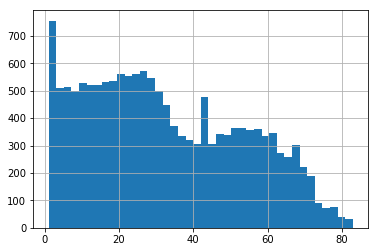

In [26]:
model_df['target_rank'].hist(bins=40)

## merge ESPN benchmarks
I scraped fantasy point projections from [ESPN](http://games.espn.com/ffl/tools/projections?) for each week in the current season and merge to holdout test set

In [27]:
proj = pd.read_json("./data/espn_projections.json")

clean_team_pos = proj['team'].str.replace('[^a-zA-Z\s]', '').str.upper().str.split(expand=True)
proj.drop(['team','position'],axis=1,inplace=True)
clean_team_pos.columns= ['team', 'position']

proj = pd.concat([proj, clean_team_pos], axis=1)

proj['team'] = proj['team'].str.replace('LAR','LA')
proj['team'] = proj['team'].str.replace('WSH','WAS')
proj['team'] = proj['team'].str.replace('LAC','SD')
proj['team'] = proj['team'].str.replace('JAX','JAC')

proj = proj[['name','position','team','week','proj_pts']]

proj.columns = ['full_name','position','team','target_week','proj_pts']
proj = proj[proj.proj_pts != '--']
proj['proj_pts'] = pd.to_numeric(proj['proj_pts'])
proj = proj[~proj.proj_pts.isnull()]
proj['full_name'] = proj.full_name.str.replace('Jr.','').str.strip()
proj['full_name'] = proj.full_name.str.replace('Sr.','').str.strip()
proj['full_name'] = proj.full_name.str.replace('III','').str.strip()
proj['full_name'] = proj.full_name.str.replace('II','').str.strip()
convert_names = {'Joshua Bellamy':'Josh Bellamy',
                 'TJ Jones':'T.J. Jones',
                 'Will Fuller V':'Will Fuller',
                 'Matthew Dayes':'Matt Dayes'}
proj['full_name'] = proj.full_name.replace(convert_names)

In [28]:
# merge ESPN projections to holdout set
merge_cols = ['full_name','position','team','target_week']
holdout = holdout.merge(proj, how='left', on=merge_cols)
holdout.dropna(inplace=True)

In [29]:
# create a rank for ESPN projections
holdout.sort_values(['year','position','week','proj_pts'], ascending=False, inplace=True)
holdout['espn_rank'] = holdout.groupby(['year','position','week'])['proj_pts'].\
                                    rank(method="dense", ascending=False)

In [30]:
holdout.shape

(3159, 400)

## trim outliers

(15126, 398)
(14054, 398)


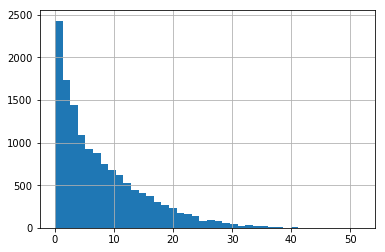

In [31]:
# trim players who scored zero in a given week because they 
# are skewing the distribution for my target variable.

thresh = 0

tmp = model_df[model_df.target > thresh]
print(model_df.shape)
print(tmp.shape)
tmp.target.hist(bins=40)

(3159, 400)
(2941, 400)


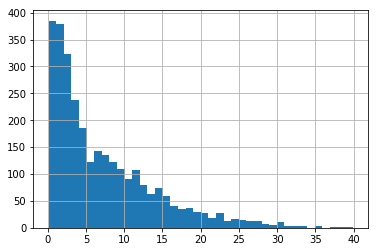

In [32]:
tmp = holdout[holdout.target > thresh]
print(holdout.shape)
print(tmp.shape)
tmp.target.hist(bins=40)

(3159, 400)
(3102, 400)


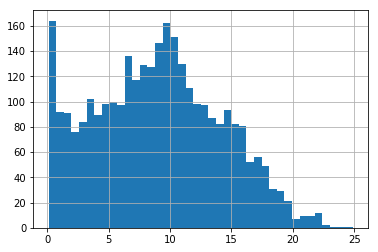

In [33]:
tmp = holdout[holdout.proj_pts > thresh]
print(holdout.shape)
print(tmp.shape)
tmp.proj_pts.hist(bins=40)

In [34]:
model_df_trimmed = model_df[model_df.target > thresh].reset_index(drop=True)
holdout_trimmed = holdout[(holdout.target > thresh) & 
                          (holdout.proj_pts > thresh)].reset_index(drop=True)

## DO NOT RUN: boxcox transform
The target distribution is pretty skewed, so I use a boxcox transform to normalize.

In [35]:
# from scipy.stats import boxcox

# model_df_trimmed['target'] = pd.Series(boxcox(model_df_trimmed.target)[0])
# holdout_trimmed['target'] = pd.Series(boxcox(holdout_trimmed.target)[0])
# holdout_trimmed['proj_pts'] = pd.Series(boxcox(holdout_trimmed.proj_pts)[0])

In [36]:
# model_df_trimmed.target.hist(bins=40)

In [37]:
# holdout_trimmed.target.hist(bins=40)

In [38]:
# holdout_trimmed.proj_pts.hist(bins=40)

## player stat interactions
The following merges serve the purpose to inform a given player of what type of offense their team employs. For instance, merging the mean QB pass/rush attempts ratio to that QB's WR gives an idea of how often the QB runs versus throwing, thus affecting the possible targets thrown to that WR.

In [39]:
numeric_df_columns = model_df_trimmed.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns
fumble_features = [c for c in numeric_df_columns if "fumble" in c and "per" not in c]

passing_features = ['passing_att_mean','passing_cmp_mean','passing_ints_mean','passing_yds_mean',
                    'passing_tds_mean','passer_ratio','PassRushRatio_Att_mean','PassRushRatio_Yds_mean',
                    'PassRushRatio_Tds_mean']

rushing_features = ['rushing_yds_mean','rushing_att_mean','rushing_tds_mean',
                    'RushRecRatio_AttRec_mean','RushRecRatio_Tds_mean','RushRecRatio_Yds_mean']

receiving_features = ['receiving_rec_mean','receiving_tds_mean','receiving_yds_mean']

sharedfeats = ['full_name','team','years_pro','age','weight','height','player_weight','year','week','target',
               'target_rank','fantasy_points_mean','target_week','defensive_matchup_allowed','offensive_snap_pct',
               'offensive_snap_tot','fd_salary','started','wind_conditions','indoor_outdoor']+fumble_features

QB_features = sharedfeats+passing_features+rushing_features
RB_features = sharedfeats+rushing_features+receiving_features
WR_features = sharedfeats+receiving_features
TE_features = sharedfeats+receiving_features

In [40]:
QB_df = model_df_trimmed[model_df_trimmed.position == 'QB'][QB_features].reset_index().drop('index',axis=1)
QB_stats = QB_df.groupby(['year','week','team']).mean()[passing_features].reset_index().add_prefix('QBMEAN')
QB_stats=QB_stats.rename(columns={'QBMEANyear':'year', 'QBMEANweek':'week', 'QBMEANteam':'team'})
QB_merge_stats = ['QBMEANPassRushRatio_Att','QBMEANPassRushRatio_Yds','QBMEANPassRushRatio_Tds']

RB_df = model_df_trimmed[model_df_trimmed.position == 'RB'][RB_features].reset_index().drop('index',axis=1)
RB_stats = RB_df.groupby(['year','week','team']).mean()[rushing_features].reset_index().add_prefix('RBMEAN')
RB_stats=RB_stats.rename(columns={'RBMEANyear':'year', 'RBMEANweek':'week', 'RBMEANteam':'team'})

WR_df = model_df_trimmed[model_df_trimmed.position == 'WR'][WR_features].reset_index().drop('index',axis=1)
WR_stats = WR_df.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('WRMEAN')
WR_stats=WR_stats.rename(columns={'WRMEANyear':'year', 'WRMEANweek':'week', 'WRMEANteam':'team'})

TE_df = model_df_trimmed[model_df_trimmed.position == 'TE'][TE_features].reset_index().drop('index',axis=1)
TE_stats = TE_df.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('TEMEAN')
TE_stats=TE_stats.rename(columns={'TEMEANyear':'year', 'TEMEANweek':'week', 'TEMEANteam':'team'})

In [41]:
print("QB:", QB_df.shape)
print("RB:", RB_df.shape)
print("WR:", WR_df.shape)
print("TE:", TE_df.shape)

QB: (1902, 60)
RB: (4638, 54)
WR: (5222, 48)
TE: (2292, 48)


In [42]:
QB_df = QB_df.merge(RB_stats, how='inner', on=['year','week','team'])

RB_df = RB_df.merge(QB_stats, how='inner', on=['year','week','team'])

WR_df = WR_df.merge(QB_stats, how='inner', on=['year','week','team'])
WR_df = WR_df.merge(RB_stats, how='inner', on=['year','week','team'])

TE_df = TE_df.merge(QB_stats, how='inner', on=['year','week','team'])
TE_df = TE_df.merge(RB_stats, how='inner', on=['year','week','team'])

In [43]:
print("QB:", QB_df.shape)
print("RB:", RB_df.shape)
print("WR:", WR_df.shape)
print("TE:", TE_df.shape)

QB: (1869, 66)
RB: (4467, 63)
WR: (5046, 63)
TE: (2218, 63)


#### holdout

In [44]:
QB_features = QB_features+['espn_rank','proj_pts']
RB_features = RB_features+['espn_rank','proj_pts']
WR_features = WR_features+['espn_rank','proj_pts']
TE_features = TE_features+['espn_rank','proj_pts']

In [45]:
QB_df_holdout = holdout_trimmed[holdout_trimmed.position == 'QB'][QB_features].reset_index().drop('index',axis=1)
QB_stats = QB_df_holdout.groupby(['year','week','team']).mean()[passing_features].reset_index().add_prefix('QBMEAN')
QB_stats=QB_stats.rename(columns={'QBMEANyear':'year', 'QBMEANweek':'week', 'QBMEANteam':'team'})
QB_merge_stats = ['QBMEANPassRushRatio_Att','QBMEANPassRushRatio_Yds','QBMEANPassRushRatio_Tds']

RB_df_holdout = holdout_trimmed[holdout_trimmed.position == 'RB'][RB_features].reset_index().drop('index',axis=1)
RB_stats = RB_df_holdout.groupby(['year','week','team']).mean()[rushing_features].reset_index().add_prefix('RBMEAN')
RB_stats=RB_stats.rename(columns={'RBMEANyear':'year', 'RBMEANweek':'week', 'RBMEANteam':'team'})

WR_df_holdout = holdout_trimmed[holdout_trimmed.position == 'WR'][WR_features].reset_index().drop('index',axis=1)
WR_stats = WR_df_holdout.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('WRMEAN')
WR_stats=WR_stats.rename(columns={'WRMEANyear':'year', 'WRMEANweek':'week', 'WRMEANteam':'team'})

TE_df_holdout = holdout_trimmed[holdout_trimmed.position == 'TE'][TE_features].reset_index().drop('index',axis=1)
TE_stats = TE_df_holdout.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('TEMEAN')
TE_stats=TE_stats.rename(columns={'TEMEANyear':'year', 'TEMEANweek':'week', 'TEMEANteam':'team'})

In [46]:
print("QB:", QB_df_holdout.shape)
print("RB:", RB_df_holdout.shape)
print("WR:", WR_df_holdout.shape)
print("TE:", TE_df_holdout.shape)

QB: (350, 62)
RB: (874, 56)
WR: (1174, 50)
TE: (508, 50)


In [47]:
QB_df_holdout = QB_df_holdout.merge(RB_stats, how='inner', on=['year','week','team'])

RB_df_holdout = RB_df_holdout.merge(QB_stats, how='inner', on=['year','week','team'])

WR_df_holdout = WR_df_holdout.merge(RB_stats, how='inner', on=['year','week','team'])
WR_df_holdout = WR_df_holdout.merge(QB_stats, how='inner', on=['year','week','team'])

TE_df_holdout = TE_df_holdout.merge(QB_stats, how='inner', on=['year','week','team'])
TE_df_holdout = TE_df_holdout.merge(RB_stats, how='inner', on=['year','week','team'])

In [48]:
print("QB:", QB_df_holdout.shape)
print("RB:", RB_df_holdout.shape)
print("WR:", WR_df_holdout.shape)
print("TE:", TE_df_holdout.shape)

QB: (350, 68)
RB: (828, 65)
WR: (1113, 65)
TE: (480, 65)


## interactions by position

In [49]:
from sklearn.preprocessing import PolynomialFeatures
create_interactions = [('QB',QB_df), ('RB',RB_df), ('WR',WR_df), ('TE',TE_df)]
interactions_positions = {}
for pos, data in create_interactions:
    numerics = data.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    data = data[numerics]
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=True)
    interactions_arr = poly.fit_transform(data)
    interactions_names = poly.get_feature_names(data.columns)
    interactions = pd.DataFrame(interactions_arr, columns=interactions_names)
    interactions_positions[pos] = interactions

def explore_interaction_corrs(pos, interactions):
    target_col = interactions['target']
    nontarget_interactions = interactions[[c for c in interactions.columns if "target" not in c]]
    explore = pd.concat([target_col, nontarget_interactions], axis=1)
    corr_interactions = explore.corr()
    return corr_interactions[['target']].sort_values('target',ascending=False).reset_index()

QB_inters = explore_interaction_corrs('QB', interactions_positions['QB'])
RB_inters = explore_interaction_corrs('RB', interactions_positions['RB'])
WR_inters = explore_interaction_corrs('WR', interactions_positions['WR'])
TE_inters = explore_interaction_corrs('TE', interactions_positions['TE'])

# QB_inters.to_csv('data/interactions_QB.csv')
# RB_inters.to_csv('data/interactions_RB.csv')
# WR_inters.to_csv('data/interactions_WR.csv')
# TE_inters.to_csv('data/interactions_TE.csv')

# QB_inters = pd.read_csv('data/interactions_QB.csv')
# RB_inters = pd.read_csv('data/interactions_RB.csv')
# WR_inters = pd.read_csv('data/interactions_WR.csv')
# TE_inters = pd.read_csv('data/interactions_TE.csv')

### QB

In [50]:
QB_inters.sort_values('target',ascending=True).head()

,index,target
1785,fd_salary chg_fumbles_tot,-0.091792
1784,fumbles_rcv_wgtmean fumbles_trcv_wgtmean,-0.087180
1783,fumbles_rcv_wgtmean fumbles_tot_wgtmean,-0.087158
1782,fumbles_yds_wgtmean rushing_yds_mean,-0.087091
1781,chg_fumbles_lost passing_tds_mean,-0.086891


### RB

In [51]:
RB_inters.sort_values('target',ascending=True).head()

,index,target
1687,fantasy_points_mean chg_fumbles_tot,-0.135982
1686,offensive_snap_tot chg_fumbles_tot,-0.135726
1685,player_weight chg_fumbles_tot,-0.135288
1684,chg_fumbles_tot rushing_yds_mean,-0.132689
1683,started chg_fumbles_tot,-0.132444


### WR

In [52]:
WR_inters.sort_values('target',ascending=True).head()

,index,target
1664,chg_fumbles_tot receiving_yds_mean,-0.115394
1663,fantasy_points_mean chg_fumbles_tot,-0.111021
1662,player_weight chg_fumbles_tot,-0.109755
1661,chg_fumbles_tot receiving_rec_mean,-0.107877
1660,offensive_snap_tot chg_fumbles_tot,-0.096767


### TE

In [53]:
TE_inters.sort_values('target',ascending=False).head(8)

,index,target
0,target,1.000000
1,height receiving_yds_mean,0.380983
2,receiving_yds_mean,0.380126
3,year receiving_yds_mean,0.380116
4,weight receiving_yds_mean,0.379562
5,age receiving_yds_mean,0.373749
6,height receiving_rec_mean,0.364913
7,receiving_rec_mean receiving_yds_mean,0.364261


## compute interactions

In [54]:
QB_df.reset_index(inplace=True,drop=True)
RB_df.reset_index(inplace=True,drop=True)
WR_df.reset_index(inplace=True,drop=True)
TE_df.reset_index(inplace=True,drop=True)

QB_df['chg_fumbles_yds trend_fumbles_tot'] = QB_df['trend_fumbles_tot']*QB_df['chg_fumbles_yds']
QB_df['age player_weight'] = QB_df['age']*QB_df['player_weight']
RB_df['player_weight offensive_snap_pct'] = RB_df['player_weight']*RB_df['offensive_snap_pct']
RB_df['fantasy_points_mean offensive_snap_tot'] = RB_df['offensive_snap_tot']*RB_df['fantasy_points_mean']
RB_df['offensive_snap_tot chg_fumbles_tot'] = RB_df['offensive_snap_tot']*RB_df['chg_fumbles_tot']
WR_df['chg_fumbles_tot receiving_yds_mean'] = WR_df['chg_fumbles_tot']*WR_df['receiving_yds_mean']
WR_df['age receiving_yds_mean'] = WR_df['age']*WR_df['receiving_yds_mean']
TE_df['trend_fumbles_tot RBMEANRushRecRatio_AttRec_mean'] = TE_df['trend_fumbles_tot']*TE_df['RBMEANRushRecRatio_AttRec_mean']
TE_df['age receiving_yds_mean'] = TE_df['age']*TE_df['receiving_yds_mean']

In [55]:
QB_df_holdout.reset_index(inplace=True,drop=True)
RB_df_holdout.reset_index(inplace=True,drop=True)
WR_df_holdout.reset_index(inplace=True,drop=True)
TE_df_holdout.reset_index(inplace=True,drop=True)

QB_df_holdout['chg_fumbles_yds trend_fumbles_tot'] = QB_df_holdout['trend_fumbles_tot']*QB_df_holdout['chg_fumbles_yds']
QB_df_holdout['age player_weight'] = QB_df_holdout['age']*QB_df_holdout['player_weight']
RB_df_holdout['player_weight offensive_snap_pct'] = RB_df_holdout['player_weight']*RB_df_holdout['offensive_snap_pct']
RB_df_holdout['fantasy_points_mean offensive_snap_tot'] = RB_df_holdout['offensive_snap_tot']*RB_df_holdout['fantasy_points_mean']
RB_df_holdout['offensive_snap_tot chg_fumbles_tot'] = RB_df_holdout['offensive_snap_tot']*RB_df_holdout['chg_fumbles_tot']
WR_df_holdout['chg_fumbles_tot receiving_yds_mean'] = WR_df_holdout['chg_fumbles_tot']*WR_df_holdout['receiving_yds_mean']
WR_df_holdout['age receiving_yds_mean'] = WR_df_holdout['age']*WR_df_holdout['receiving_yds_mean']
TE_df_holdout['trend_fumbles_tot RBMEANRushRecRatio_AttRec_mean'] = TE_df_holdout['trend_fumbles_tot']*TE_df_holdout['RBMEANRushRecRatio_AttRec_mean']
TE_df_holdout['age receiving_yds_mean'] = TE_df_holdout['age']*TE_df_holdout['receiving_yds_mean']

## memory mgmt

In [56]:
del player_dfs
del opp_dfs
del nfl_dfs
del fanduel_dfs
del nfl_fanduel_dfs
del nfl_fd_sc_dfs
del nfl_fd_sc_weather_dfs
del QB_inters
del RB_inters
del WR_inters
del TE_inters
del interactions_positions
gc.collect()

991

## regression model

In [57]:
import sklearn.metrics as metrics
import sklearn.linear_model as lin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from pprint import pprint
import matplotlib
from math import exp
from sklearn.utils import shuffle

In [98]:
RESPONSE_VAR = 'target'
BENCHMARK = 'proj_pts'
CURR_WEEK = 14

In [163]:
def regression_tts(input_df, week, response):
    
    """Run a regression for each position (QB,RB,WR,TE),
       Train on first 14 weeks of each season 2013-2016,
       Test on last 3 weeks of each season 2013-2016"""
    
    features = input_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    features.remove('year')
    features.remove('target')
    features.remove('target_rank')
    features.remove('target_week')
    
    est = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1)
#     est = lin.LassoCV()
    
    df_train = input_df[input_df.target_week <= week]
#     df_train.sort_values('fantasy_points_mean',ascending=True,inplace=True)
    df_test = input_df[input_df.target_week > week]
    
    X_train = df_train[features]
    y_train = df_train[response]
    X_test = df_test[features]
    y_test = df_test[response]
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)
    
#     sw = np.linspace(.01,1,X_train.shape[0])
    est.fit(X_train, y_train)

    y_pred = est.predict(X_train)
    train_results = (metrics.mean_squared_error(y_train, y_pred))**(0.5)
#     train_results = metrics.r2_score(y_train, y_pred)

    y_pred = est.predict(X_test)
    test_results = (metrics.mean_squared_error(y_test, y_pred))**(0.5)
#     test_results = metrics.r2_score(y_test, y_pred)
    
    df_test = df_test.reset_index()[['target_week','fantasy_points_mean',response]]
    df_test['MODEL_PRED'] = pd.Series(y_pred)
    df_test['RESIDUALS'] = df_test['MODEL_PRED'] - df_test[response]
    
    coefs = None
    if 'sklearn.linear_model' in est.__module__:
        coef_ranks = list(zip(abs(est.coef_), est.coef_, features))
        coefs = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
    else:
        coef_ranks = list(zip(est.feature_importances_, features))
        coefs = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
        
    return test_results, train_results, est, coefs, df_test

In [164]:
coefs_all = {}
ests_positions = {}
resids_positions = []

for pos, data in [('QB',QB_df),('RB',RB_df),('WR',WR_df),('TE',TE_df)]:
    print(pos)
    results_test, results_train, est, coefs, resids = regression_tts(data, CURR_WEEK, RESPONSE_VAR)
    
    print('train results:',results_train)
    print('test  results:',results_test)
    coefs_all[pos] = coefs
    ests_positions[pos] = est
    resids['position'] = pos
    resids_positions.append(resids)

QB
train results: 6.71983298369
test  results: 7.80652086888
RB
train results: 5.47723068253
test  results: 5.8084739927
WR
train results: 5.52691685336
test  results: 5.23941922685
TE
train results: 4.08313886523
test  results: 4.21756593754


In [165]:
for pos in coefs_all.keys():
    print(pos)
    pprint(coefs_all[pos][:4])

QB
[(0.14300964366336238, 'fd_salary'),
 (0.12806194933898976, 'player_weight'),
 (0.062770992765597194, 'passing_yds_mean'),
 (0.061638734002154257, 'offensive_snap_tot')]
WR
[(0.15186476231912494, 'receiving_yds_mean'),
 (0.102624103918001, 'fd_salary'),
 (0.073241829343239764, 'fantasy_points_mean'),
 (0.059645807624520333, 'player_weight')]
RB
[(0.29475084797471401, 'fantasy_points_mean offensive_snap_tot'),
 (0.08790939907612913, 'offensive_snap_tot'),
 (0.077457489887096775, 'rushing_yds_mean'),
 (0.071614353944568221, 'rushing_att_mean')]
TE
[(0.15096438758136266, 'receiving_rec_mean'),
 (0.11158696628327316, 'receiving_yds_mean'),
 (0.098962671106620312, 'fd_salary'),
 (0.070063382861525345, 'age receiving_yds_mean')]


In [166]:
QB_coefs_plot = [x[0] for x in coefs_all['QB']][:3]
RB_coefs_plot = [x[0] for x in coefs_all['RB']][:3]
WR_coefs_plot = [x[0] for x in coefs_all['WR']][:3]
TE_coefs_plot = [x[0] for x in coefs_all['TE']][:3]

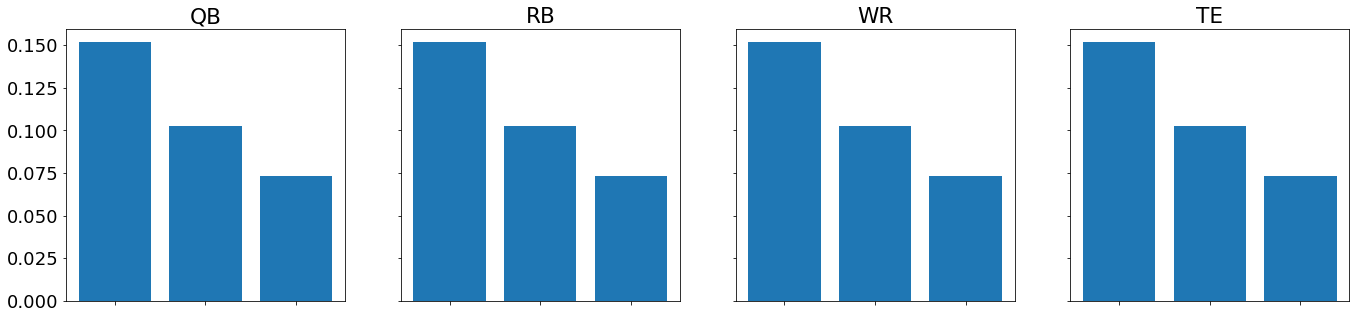

In [167]:
font = {'size'   : 18}
matplotlib.rc('font', **font)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(23,5), sharey=True)

for ax, title, pos_coefs in [(ax1,'QB',QB_coefs_plot), (ax2,'RB',RB_coefs_plot),
                      (ax3,'WR',WR_coefs_plot), (ax4,'TE',TE_coefs_plot)]:
    ax.bar(range(len(WR_coefs_plot)),WR_coefs_plot)
    ax.set_title(title)
    ax.axes.xaxis.set_ticklabels([])

## model output

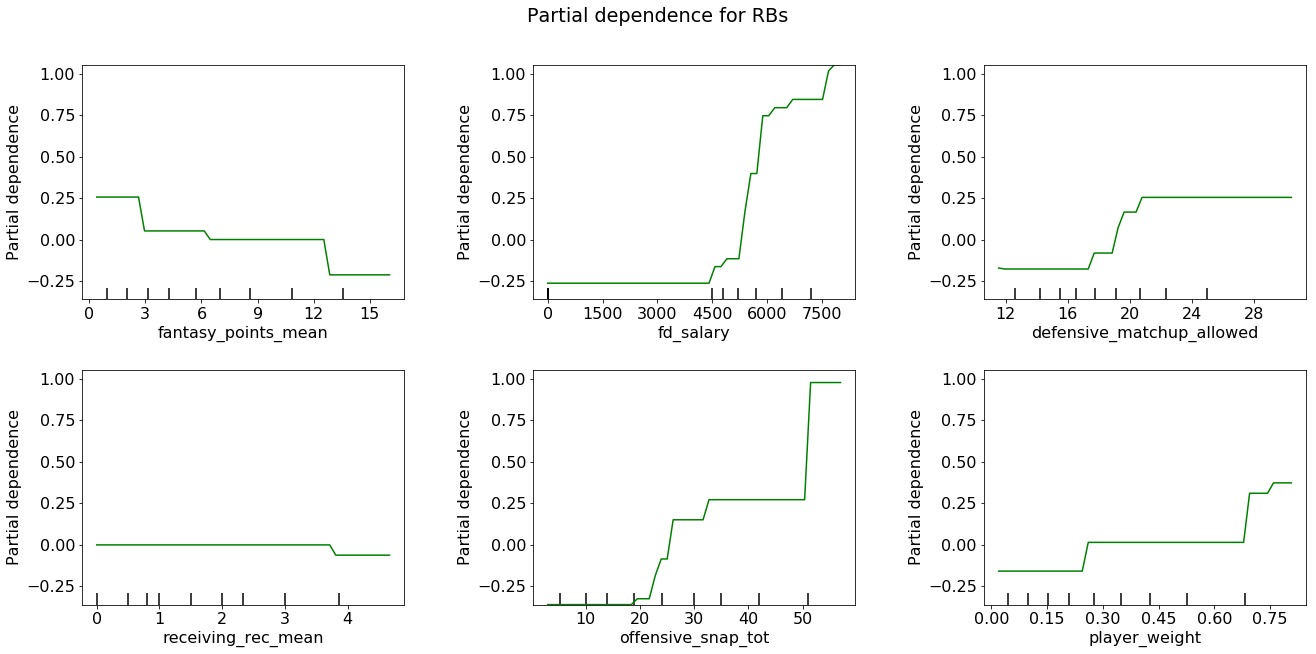

In [133]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
font = {'size'   : 16}
matplotlib.rc('font', **font)

features = RB_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
features.remove('year')
features.remove('target')
features.remove('target_rank')
features.remove('target_week')

fp_mean = features.index('fantasy_points_mean')
fd_sal = features.index('fd_salary')
pr = features.index('receiving_rec_mean')
pw = features.index('player_weight')
dpa = features.index('defensive_matchup_allowed')
snaps = features.index('offensive_snap_tot')
X_train = RB_df[features]
X_train = X_train[X_train.week < CURR_WEEK].as_matrix()

features_idx = [fp_mean, fd_sal, dpa, pr, snaps, pw]
fig, axs = plot_partial_dependence(ests_positions['RB'], X_train, features_idx,
                                   feature_names=features,
                                   n_jobs=-1, grid_resolution=50, figsize=(20,10))
fig.suptitle('Partial dependence for RBs')
plt.subplots_adjust(top=0.9) 

In [134]:
model_results = pd.concat(resids_positions)
model_results = model_results.sort_values('MODEL_PRED').reset_index()
model_results_QB = resids_positions[0].sort_values('MODEL_PRED').reset_index()
model_results_RB = resids_positions[1].sort_values('MODEL_PRED').reset_index()
model_results_WR = resids_positions[2].sort_values('MODEL_PRED').reset_index()
model_results_TE = resids_positions[3].sort_values('MODEL_PRED').reset_index()

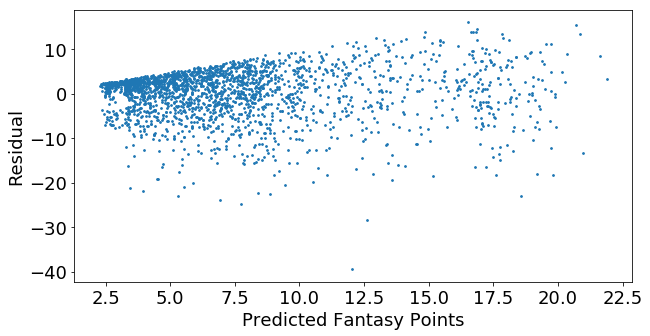

In [161]:
plt.figure(figsize=(10,5))
plt.scatter(model_results.MODEL_PRED, model_results.RESIDUALS, s=3)
plt.ylabel('Residual')
plt.xlabel('Predicted Fantasy Points')

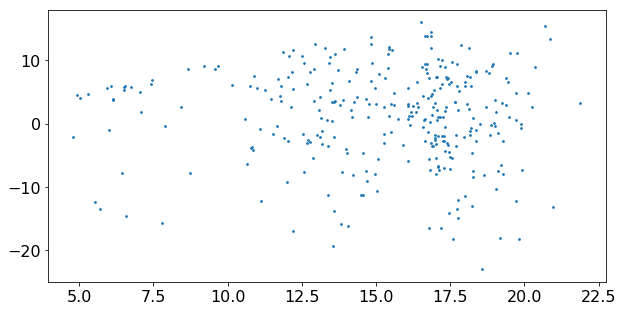

In [136]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_QB.MODEL_PRED, model_results_QB.RESIDUALS, s=3)

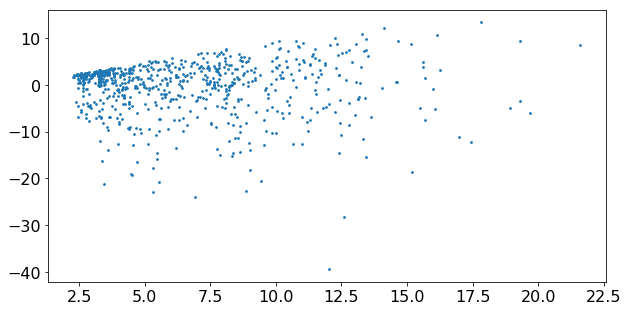

In [137]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_RB.MODEL_PRED, model_results_RB.RESIDUALS, s=3)

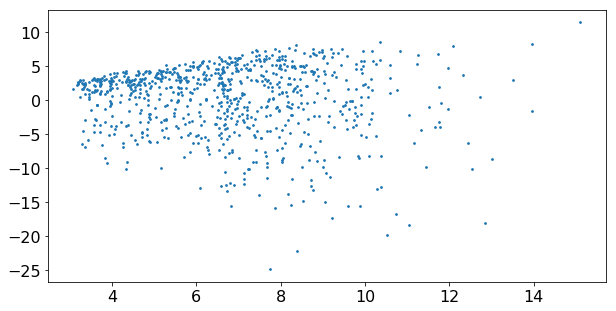

In [138]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_WR.MODEL_PRED, model_results_WR.RESIDUALS, s=3)

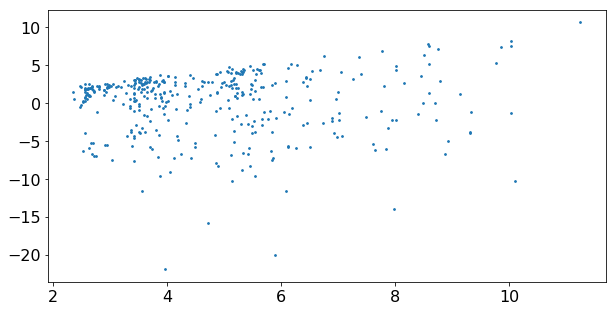

In [139]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_TE.MODEL_PRED, model_results_TE.RESIDUALS, s=3)

0.103422662492
1.4348994053474649


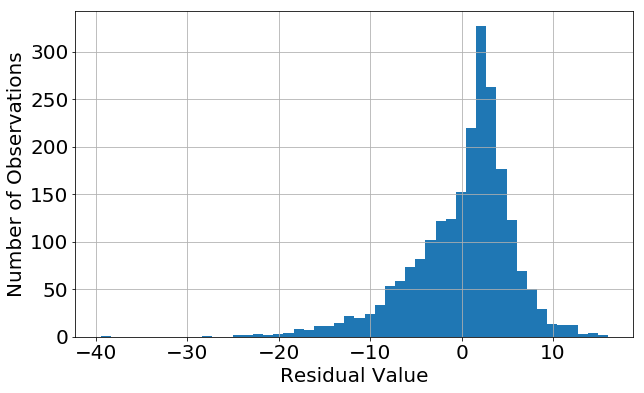

In [140]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,6))
model_results.RESIDUALS.hist(bins=50)
plt.xlabel("Residual Value")
plt.ylabel("Number of Observations")
print(model_results.RESIDUALS.mean())
print(model_results.RESIDUALS.median())

## holdout test

In [162]:
# weeks = sorted(model_df.target_week.unique().tolist())
# weeks.remove(1.0)
# weeks.remove(2.0)
weeks_predict = list(range(2,CURR_WEEK))

In [168]:
def weekly_regression_predict(input_df, weeks, est, response, espn_response):

    features = input_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    features.remove('year')
    features.remove('target')
    features.remove('target_rank')
    features.remove('proj_pts')
    features.remove('espn_rank')
    
    week_nums = []
    scores = []
    bmk_scores = []
    predictions = []

    for week in weeks:
        week_nums.append(week)
       
        df_cv = input_df[input_df.target_week == week]
        X = df_cv[features]
        y = df_cv[response]
        y_benchmark = df_cv[espn_response]
#         X.sort_values('fantasy_points_mean',ascending=True,inplace=True)
        ss = StandardScaler()
        X = ss.fit_transform(X)
        
        y_pred = est.predict(X)

#         score = metrics.r2_score(y, y_pred)
#         score = (metrics.mean_squared_error(y, y_pred))**(0.5)
        score = metrics.mean_absolute_error(y, y_pred)
        scores.append(score)
    
#         bmk_score = metrics.r2_score(y, y_benchmark)
#         bmk_score = (metrics.mean_squared_error(y, y_benchmark))**(0.5)
        bmk_score = metrics.mean_absolute_error(y, y_benchmark)
        bmk_scores.append(bmk_score)
        
        predicts = df_cv.reset_index()[['full_name','target_week', response, espn_response]]
        predicts['PREDICTION'] = pd.Series(y_pred)
        predicts['ERROR'] = predicts['PREDICTION'] - predicts[response]
        predicts['ESPN_ERROR'] = predicts[espn_response] - predicts[response]
        predictions.append(predicts)
        
    return week_nums, scores, bmk_scores, pd.concat(predictions)

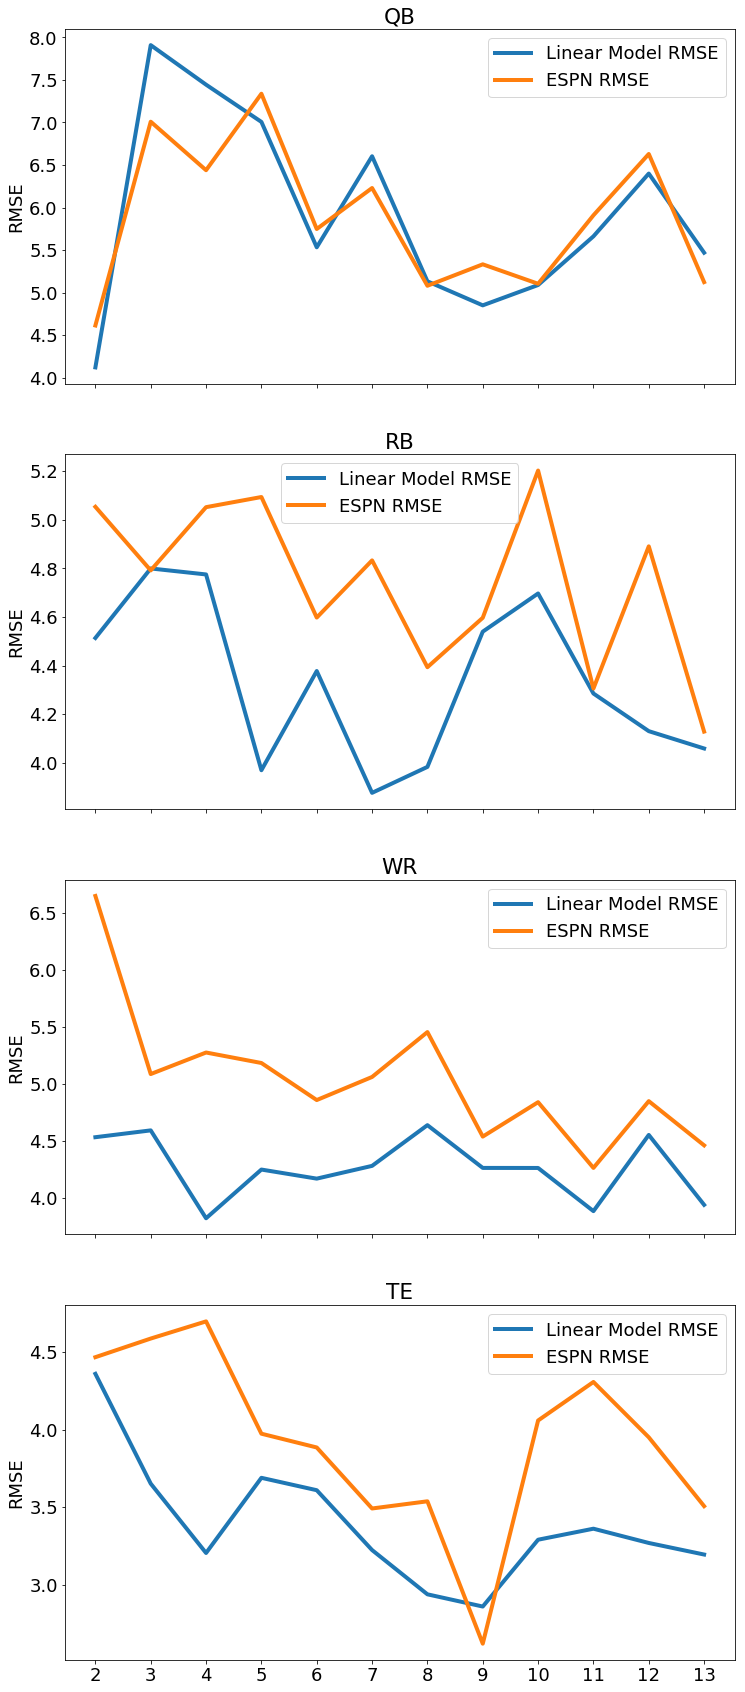

In [169]:
prediction_dfs = {}

f, (ax2, ax3, ax4, ax5) = plt.subplots(4,figsize=(12,30), sharex=True)
for pos, data, ax in [('QB',QB_df_holdout,ax2),
                      ('RB',RB_df_holdout,ax3),
                      ('WR',WR_df_holdout,ax4),
                      ('TE',TE_df_holdout,ax5)]:
    
    weeks, scores, bmk_scores, predictions = weekly_regression_predict(data, weeks_predict, 
                                                                       ests_positions[pos],
                                                                       response=RESPONSE_VAR,
                                                                       espn_response=BENCHMARK)
    predictions['position'] = pos
    prediction_dfs[pos] = predictions
    
    ax.plot(weeks, scores, label="Linear Model RMSE", linewidth=4)
    ax.plot(weeks, bmk_scores, label="ESPN RMSE", linewidth=4)
    ax.set_xticks(weeks)
    ax.set_ylabel("RMSE")
    ax.set_title(pos)
    ax.legend()

In [170]:
holdout_results = pd.concat(list(prediction_dfs.values()))

5.62152838173
6.12655248797


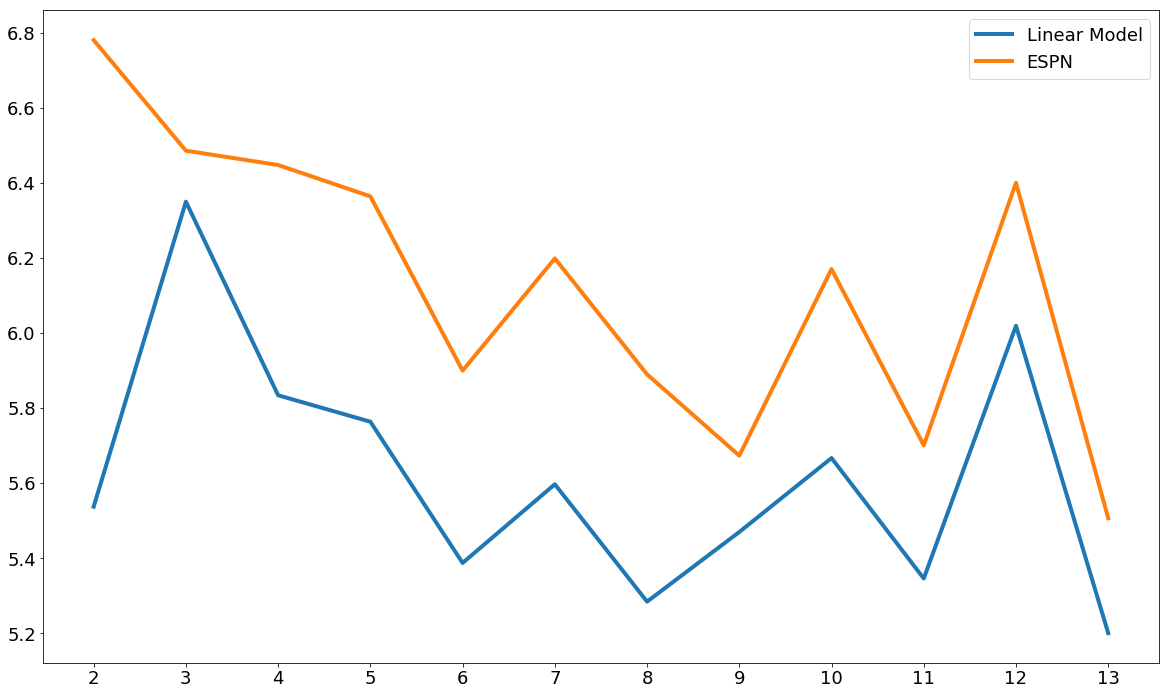

In [171]:
weeks_all = []
all_scores = []
all_bmk_scores = []
for week in weeks_predict:
    weeks_all.append(week)
    weeks_results = holdout_results[holdout_results.target_week == week]
    y = weeks_results[RESPONSE_VAR]
    y_pred = weeks_results['PREDICTION']
    y_bmk = weeks_results[BENCHMARK]
#     score = metrics.r2_score(y, y_pred)
#     bmk_score = metrics.r2_score(y, y_bmk)
    score = (metrics.mean_squared_error(y, y_pred))**(0.5)
    bmk_score = (metrics.mean_squared_error(y, y_bmk))**(0.5)
    all_scores.append(score)
    all_bmk_scores.append(bmk_score)
    
print(np.mean(all_scores))
print(np.mean(all_bmk_scores))
plt.figure(figsize=(20,12))
plt.plot(weeks_all, all_scores, label="Linear Model", linewidth=4)
plt.plot(weeks_all, all_bmk_scores, label="ESPN", linewidth=4)
plt.xticks(weeks_all)
# plt.ylabel("RMSE")
# plt.xlabel("Week")
# plt.title("Holdout error for all positions (2017 season)")
plt.legend()

In [172]:
position_q = 'RB'
name = 'LeSean McCoy'
holdout_results[(holdout_results.position == position_q) &
                (holdout_results.full_name == name)]

,full_name,target_week,target,proj_pts,PREDICTION,ERROR,ESPN_ERROR,position
9,LeSean McCoy,2,4.3,14.5,12.701790,8.401790,10.2,RB
3,LeSean McCoy,3,6.9,17.0,9.634204,2.734204,10.1,RB
3,LeSean McCoy,4,10.8,19.7,11.749000,0.949000,8.9,RB
4,LeSean McCoy,5,8.9,19.2,10.135325,1.235325,10.3,RB
60,LeSean McCoy,7,22.2,20.8,13.789225,-8.410775,-1.4,RB
2,LeSean McCoy,8,23.3,21.9,13.892795,-9.407205,-1.4,RB
2,LeSean McCoy,9,2.5,21.9,18.986945,16.486945,19.4,RB
0,LeSean McCoy,10,6.0,21.0,13.402418,7.402418,15.0,RB
2,LeSean McCoy,11,24.6,19.8,9.777387,-14.822613,-4.8,RB
1,LeSean McCoy,12,7.9,20.1,11.828062,3.928062,12.2,RB


In [173]:
holdout_results['abs_error'] = holdout_results.ERROR.apply(lambda x: np.abs(x))
holdout_results['spread'] = np.abs(holdout_results['ERROR'] - holdout_results['ESPN_ERROR'])

In [174]:
holdout_results.sort_values('spread', ascending=False).head(20)

,full_name,target_week,target,proj_pts,PREDICTION,ERROR,ESPN_ERROR,position,abs_error,spread
21,Tyrod Taylor,11,18.12,0.1,17.810070,-0.309930,-18.02,QB,0.309930,17.710070
26,Case Keenum,5,11.80,0.1,14.832260,3.032260,-11.70,QB,3.032260,14.732260
31,Trevor Siemian,12,14.86,0.1,14.174078,-0.685922,-14.76,QB,0.685922,14.074078
24,Ryan Fitzpatrick,9,9.72,0.1,12.989316,3.269316,-9.62,QB,3.269316,12.889316
26,Matt Moore,11,15.28,0.1,12.451871,-2.828129,-15.18,QB,2.828129,12.351871
0,Rob Gronkowski,2,17.60,19.2,7.227893,-10.372107,1.60,TE,10.372107,11.972107
0,Le'Veon Bell,2,9.10,20.5,8.656121,-0.443879,11.40,RB,0.443879,11.843879
75,Antonio Brown,10,4.70,22.1,10.602481,5.902481,17.40,WR,5.902481,11.497519
8,Odell Beckham,3,19.90,16.8,5.593743,-14.306257,-3.10,WR,14.306257,11.206257
28,Cody Kessler,10,0.20,0.1,11.098470,10.898470,-0.10,QB,10.898470,10.998470
